<a href="https://colab.research.google.com/github/visith1577/Machine-learning-first-projects/blob/main/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np 
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from datetime import datetime
from glob import glob
from collections import Counter

In [2]:
import tensorflow as tf

In [3]:
#get data (yale faces dataset)
#!wget -nc https://lazyprogrammer.me/course_files/yalefaces.zip

In [4]:
#!unzip yalefaces.zip

In [5]:
files = glob('yalefaces/subject*')

In [6]:
np.random.shuffle(files)

In [7]:
N = len(files)
N

166

In [8]:
H, W = 80, 80

def load_images(file_path):
  image = tf.keras.preprocessing.image.load_img
  img = tf.keras.preprocessing.image.img_to_array(image(file_path, target_size=[H,W])).astype('uint8')
  return img

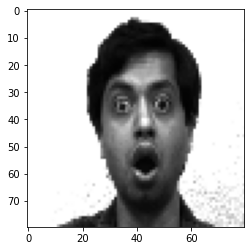

In [9]:
img = load_images(np.random.choice(files))
plt.imshow(img)
plt.show()

In [10]:
img.shape

(80, 80, 3)

In [11]:
def to_greyscale(img):
  return img.mean(axis=-1)

In [12]:
np.all(img[:,:,0] == img[:,:,1]), np.all(img[:,:,0] == img[:,:,2])

(True, True)

In [13]:
#load images as arrays
shape = [N, H, W]
images = np.zeros(shape)
for i, f in enumerate(files):
  img = to_greyscale(load_images(f))/255.0
  images[i] = img

In [14]:
labels = np.zeros(N)
for i, f in enumerate(files):
  filename = f.rsplit('/', 1)[-1]
  subject_name = filename.split('.', 1)[0]

  idx = int(subject_name.replace('subject', '')) - 1
  labels[i] = idx

In [15]:
label_count = Counter(labels)

In [16]:
label_count

Counter({0.0: 12,
         1.0: 11,
         2.0: 11,
         3.0: 11,
         4.0: 11,
         5.0: 11,
         6.0: 11,
         7.0: 11,
         8.0: 11,
         9.0: 11,
         10.0: 11,
         11.0: 11,
         12.0: 11,
         13.0: 11,
         14.0: 11})

In [17]:
unique_labels = set(label_count.keys())

In [18]:
unique_labels

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0}

In [19]:
n_subjects = len(label_count)

In [20]:
n_subjects

15

In [21]:
n_test = 3*n_subjects
n_train = N - n_test

In [22]:
train_images = np.zeros((n_train, H, W))
test_images = np.zeros((n_test, H, W))
test_labels = np.zeros((n_test))
train_labels = np.zeros((n_train))

In [23]:
count_so_far = {}
train_idx = 0
test_idx = 0
images, labels = shuffle(images, labels)

for img, label in zip(images, labels):
  count_so_far[label] = count_so_far.get(label, 0) + 1
  if count_so_far[label] > 3:
    train_images[train_idx] = img
    train_labels[train_idx] = label
    train_idx += 1

  else:
    test_images[test_idx] = img
    test_labels[test_idx] = label
    test_idx += 1

In [24]:
train_label2idx = {}
test_label2idx = {}

for i, label in enumerate(train_labels):
  if label not in train_label2idx:
    train_label2idx[label] = [i]
  else:  
    train_label2idx[label].append(i)

for i, label in enumerate(test_labels):
  if label not in test_label2idx:
    test_label2idx[label] = [i]
  else:  
    test_label2idx[label].append(i)


In [25]:
train_positives = []
train_negatives = []
test_positives = []
test_negatives = []

for label, indices in train_label2idx.items():
  other_indices = set(range(n_train)) - set(indices)

  for i, idx1 in enumerate(indices):
    for idx2 in  indices[i+1:]:
      train_positives.append((idx1, idx2))

    for idx2 in other_indices:
      train_negatives.append((idx1, idx2))

for label, indices in test_label2idx.items():
  other_indices = set(range(n_test)) - set(indices)

  for i, idx1 in enumerate(indices):
    for idx2 in  indices[i+1:]:
      test_positives.append((idx1, idx2))

    for idx2 in other_indices:
      test_negatives.append((idx1, idx2))       



In [26]:
batch_size = 64
def train_generator():
 
  n_batches = int(np.ceil(len(train_positives) / batch_size))
  
  while True:
    np.random.shuffle(train_positives)
    n_samples = batch_size * 2
    shape = (n_samples, H, W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    for i in range(n_batches):
      pos_batch_indices = train_positives[i * batch_size: (i + 1) * batch_size]

      
      j = 0
      for idx1, idx2 in pos_batch_indices:
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 1 
        j += 1

      
      neg_indices = np.random.choice(len(train_negatives), size=len(pos_batch_indices), replace=False)
      for neg in neg_indices:
        idx1, idx2 = train_negatives[neg]
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 0 
        j += 1

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]

      
      x1 = x1.reshape(-1, 1, H, W)
      x2 = x2.reshape(-1, 1, H, W)

      
      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1, x2], y

In [27]:

def test_generator():
  n_batches = int(np.ceil(len(test_positives) / batch_size))

  while True:
    n_samples = batch_size * 2
    shape = (n_samples, H, W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    for i in range(n_batches):
      pos_batch_indices = test_positives[i * batch_size: (i + 1) * batch_size]

      
      j = 0
      for idx1, idx2 in pos_batch_indices:
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 1 
        j += 1

      
      neg_indices = np.random.choice(len(test_negatives), size=len(pos_batch_indices), replace=False)
      for neg in neg_indices:
        idx1, idx2 = test_negatives[neg]
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 0 
        j += 1

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]

  
      x1 = x1.reshape(-1, 1, H, W)
      x2 = x2.reshape(-1, 1, H, W)

  
      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1, x2], y

In [56]:
class Siamese(nn.Module):
  def __init__(self, feature_dim):
    super(Siamese, self).__init__()

    self.cnn = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(18*18*32, 128),
        nn.ReLU(),
        nn.Linear(128, feature_dim)
        
      )
  def forward(self, im1, im2):
      feat1 = self.cnn(im1)
      feat2 = self.cnn(im2)

      return torch.norm(feat1 - feat2, dim=-1)

In [57]:
model = Siamese(50)

In [58]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

Siamese(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=10368, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [59]:
def contrastive_loss(y, t):
  nonmatch = F.relu(1 - y)
  return torch.mean(t * y**2 + (1 - t)*(nonmatch)**2)

In [60]:
optimizer = torch.optim.Adam(model.parameters())

In [61]:
def batch_gd(
    model,
    criterion,
    optimizer,
    train_gen,
    test_gen,
    train_steps_per_epoch,
    test_steps_per_epoch,
    epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    steps = 0
    for (x1, x2), targets in train_gen:
      # move data to GPU
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(x1, x2)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      # Update steps
      steps += 1
      if steps >= train_steps_per_epoch:
        break

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    steps = 0
    for (x1, x2), targets in test_gen:
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)
      outputs = model(x1, x2)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
      steps += 1
      if steps >= train_steps_per_epoch:
        break
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [62]:
train_steps = int(np.ceil(len(train_positives) / batch_size))
test_steps = int(np.ceil(len(test_positives) / batch_size))

train_losses, test_losses = batch_gd(
    model,
    contrastive_loss,
    optimizer,
    train_generator(),
    test_generator(),
    train_steps,
    test_steps,
    epochs=20)

Epoch 1/20, Train Loss: 0.4826,       Test Loss: 0.2176, Duration: 0:00:00.902061
Epoch 2/20, Train Loss: 0.1632,       Test Loss: 0.1111, Duration: 0:00:00.851547
Epoch 3/20, Train Loss: 0.0906,       Test Loss: 0.1180, Duration: 0:00:00.852262
Epoch 4/20, Train Loss: 0.0691,       Test Loss: 0.0822, Duration: 0:00:00.852450
Epoch 5/20, Train Loss: 0.0456,       Test Loss: 0.0863, Duration: 0:00:00.854443
Epoch 6/20, Train Loss: 0.0311,       Test Loss: 0.0907, Duration: 0:00:00.852640
Epoch 7/20, Train Loss: 0.0207,       Test Loss: 0.0901, Duration: 0:00:00.851469
Epoch 8/20, Train Loss: 0.0161,       Test Loss: 0.0823, Duration: 0:00:00.852821
Epoch 9/20, Train Loss: 0.0099,       Test Loss: 0.0849, Duration: 0:00:00.853602
Epoch 10/20, Train Loss: 0.0082,       Test Loss: 0.0893, Duration: 0:00:00.855097
Epoch 11/20, Train Loss: 0.0060,       Test Loss: 0.0807, Duration: 0:00:00.854206
Epoch 12/20, Train Loss: 0.0048,       Test Loss: 0.0857, Duration: 0:00:00.856695
Epoch 13/20, 

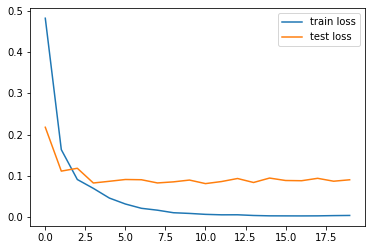

In [63]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [64]:
model.eval()

Siamese(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=10368, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [65]:
def predict(x1, x2):
  x1 = torch.from_numpy(x1).float().to(device)
  x2 = torch.from_numpy(x2).float().to(device)
  with torch.no_grad():
    dist = model(x1, x2).cpu().numpy()
    return dist.flatten()

In [66]:
# calculate accuracy before training
# since the dataset is imbalanced, we'll report tp, tn, fp, fn
def get_train_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = 64
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))
  n_batches = int(np.ceil(len(train_positives) / batch_size))
  for i in range(n_batches):
    print(f"pos batch: {i+1}/{n_batches}")
    pos_batch_indices = train_positives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indices:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  n_batches = int(np.ceil(len(train_negatives) / batch_size))
  for i in range(n_batches):
    print(f"neg batch: {i+1}/{n_batches}")
    neg_batch_indices = train_negatives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indices:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()

  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)
  print(f"sensitivity (tpr): {tpr}, specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

In [67]:
def get_test_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = 64
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))
  n_batches = int(np.ceil(len(test_positives) / batch_size))
  for i in range(n_batches):
    print(f"pos batch: {i+1}/{n_batches}")
    pos_batch_indices = test_positives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indices:
      x_batch_1[j,0] = test_images[idx1]
      x_batch_2[j,0] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  n_batches = int(np.ceil(len(test_negatives) / batch_size))
  for i in range(n_batches):
    print(f"neg batch: {i+1}/{n_batches}")
    neg_batch_indices = test_negatives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indices:
      x_batch_1[j] = test_images[idx1]
      x_batch_2[j] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()


  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)
  print(f"sensitivity (tpr): {tpr}, specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

pos batch: 1/7
pos batch: 2/7
pos batch: 3/7
pos batch: 4/7
pos batch: 5/7
pos batch: 6/7
pos batch: 7/7
neg batch: 1/214
neg batch: 2/214
neg batch: 3/214
neg batch: 4/214
neg batch: 5/214
neg batch: 6/214
neg batch: 7/214
neg batch: 8/214
neg batch: 9/214
neg batch: 10/214
neg batch: 11/214
neg batch: 12/214
neg batch: 13/214
neg batch: 14/214
neg batch: 15/214
neg batch: 16/214
neg batch: 17/214
neg batch: 18/214
neg batch: 19/214
neg batch: 20/214
neg batch: 21/214
neg batch: 22/214
neg batch: 23/214
neg batch: 24/214
neg batch: 25/214
neg batch: 26/214
neg batch: 27/214
neg batch: 28/214
neg batch: 29/214
neg batch: 30/214
neg batch: 31/214
neg batch: 32/214
neg batch: 33/214
neg batch: 34/214
neg batch: 35/214
neg batch: 36/214
neg batch: 37/214
neg batch: 38/214
neg batch: 39/214
neg batch: 40/214
neg batch: 41/214
neg batch: 42/214
neg batch: 43/214
neg batch: 44/214
neg batch: 45/214
neg batch: 46/214
neg batch: 47/214
neg batch: 48/214
neg batch: 49/214
neg batch: 50/214
neg 

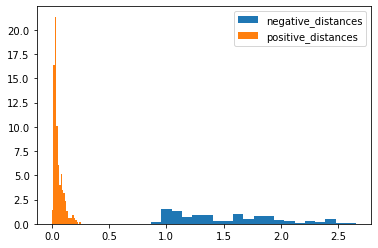

In [68]:
get_train_accuracy(0.65)

pos batch: 1/1
neg batch: 1/30
neg batch: 2/30
neg batch: 3/30
neg batch: 4/30
neg batch: 5/30
neg batch: 6/30
neg batch: 7/30
neg batch: 8/30
neg batch: 9/30
neg batch: 10/30
neg batch: 11/30
neg batch: 12/30
neg batch: 13/30
neg batch: 14/30
neg batch: 15/30
neg batch: 16/30
neg batch: 17/30
neg batch: 18/30
neg batch: 19/30
neg batch: 20/30
neg batch: 21/30
neg batch: 22/30
neg batch: 23/30
neg batch: 24/30
neg batch: 25/30
neg batch: 26/30
neg batch: 27/30
neg batch: 28/30
neg batch: 29/30
neg batch: 30/30
sensitivity (tpr): 0.8444444444444444, specificity (tnr): 0.9798941798941799


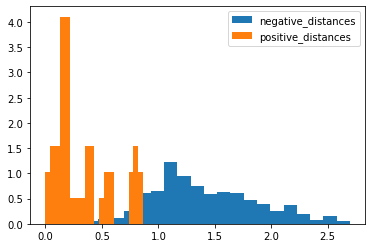

In [69]:
get_test_accuracy(0.65)